In [1]:
from tinygrad.graph import print_tree
from tinygrad.helpers import dtypes
from tinygrad.jit import TinyJit
from tinygrad.nn import Linear, Embedding
from tinygrad.nn.optim import Adam
from tinygrad.nn.state import get_parameters
from tinygrad.ops  import ConstBuffer, UnaryOps, LoadOps
from tinygrad.tensor import Tensor, Function
from tinygrad.lazy import LazyBuffer
from tinygrad.shape.shapetracker import ShapeTracker

from matplotlib import pyplot as plt
import numpy as np

In [2]:
X,Y,B,C = 20,22,5,6
labels = Tensor(np.random.randint(0,C,size=(B,Y)))

In [3]:
def imshow(x):
    if isinstance(x,Tensor): x = x.numpy()
    while len(x.shape) > 2: x = x[:,:,0]
    plt.imshow(x[:,:])
    plt.show()

In [58]:
class Model:
    def __init__(self, C:int,hdim = 10):
        self.C = C
        self.hdim = hdim
        self.input_emb = Embedding(C,hdim)   
        self.out_emb = Embedding(C,hdim)
        self.lin = Linear(hdim*2, C+1)

    def distribution(self, labels):
        B,N = labels.shape
        X = self.input_emb( labels)
        Y = self.out_emb (labels.pad(((0,0),(1,0))))

        d = Tensor.cat(X.unsqueeze(2).expand((-1,-1,N+1,-1)), Y.unsqueeze(1).expand((-1,N,-1,-1)),dim=-1)
        d = self.lin(d)
        return d

In [59]:
def logsumexp(a:Tensor, b:Tensor):
    mx = Tensor.maximum(a,b).maximum(-1e10)
    s = (a-mx).exp() + (b-mx).exp()
    return s.log() + mx
inf = float('inf')

def shear(d:Tensor,value = 0):
    B,X,Y,C = d.shape
    d = d.pad(((0,0),(0,Y),(0,0),(0,0)),value=value)
    d = d.transpose(1,2).reshape((B,-1,C))
    d = d[:,:(X+Y-1)*Y,:].realize()
    return d.reshape((B,Y,X+Y-1,C)).transpose(1,2)

def unshear(x:Tensor):
    B,X,Y = x.shape
    x = x.reshape((B,-1,))
    x = x.pad(((0,0),(0,X),))
    x = x.reshape((B,X,Y+1))
    return x.shrink(((0,B),(0,X),(0,Y+1-X)))

class TransducerLoss(Function):

    def forward(self, d:Tensor, labels:Tensor):
        self.B,self.X,self.Y,self.C = d.shape

        self.labels = Tensor(labels).pad(((0,0),(0,1)))
        self.lattice = shear(Tensor(d))
        self.X = self.X+self.Y-1
        assert self.lattice.shape == (self.B,self.X,self.Y,self.C), f"{self.lattice.shape}"

        self.skip = self.lattice[:,:,:,-1].log()
        self.p = self.lattice[
            Tensor(np.arange(self.B).reshape((-1,1,1))),
            Tensor(np.arange(self.X).reshape((1,-1,1))),
            Tensor(np.arange(self.Y).reshape((1,1,-1))),
            self.labels.reshape((self.B,1,-1))].log()

        assert self.p.shape == (self.B, self.X, self.Y)
        self.a = [Tensor([0]*self.B).reshape(-1,1).pad(((0,0),(0,self.Y-1),),-inf).realize()]

        for x in range(0,self.X-1):
            self.a.append(logsumexp((self.a[-1] + self.skip[:,x,:]).realize(), (self.a[-1][:,:-1].pad(((0,0),(1,0),),-inf).realize() + self.p[:,x,:-1].pad(((0,0),(1,0),),-inf)).realize()))

        return (-self.a[-1][:,-1] - self.skip[:,-1,-1]).sum().lazydata
    
    def backward(self, g):

        self.b = [None] * (self.X-1) + [Tensor.ones(self.B,self.Y)]
        for x in range(self.X-2,-1,-1):
            self.b[x] = (
                logsumexp(
                self.b[x+1] + self.skip[:,x,:],
                self.b[x+1][:,1:].pad(((0,0),(0,1),),-inf).realize() + self.p[:,x,:].realize()
             )).realize()

        self.skg, self.p_grad = None, None

        for a,b in zip(self.a[:-1], self.b[1:]):
            sg = (a + b).reshape(self.B, 1,-1)
            self.skg = sg if self.skg is None else self.skg.cat(sg,dim=1).realize()
            pg = a.unsqueeze(1) + b[:,1:].pad(((0,0),(0,1),),-inf).unsqueeze(1)
            self.p_grad = pg if self.p_grad is None else self.p_grad.cat(pg,dim=1).realize()

        self.skg = (unshear(Tensor.cat(self.skg,(self.a[-1] + self.b[-1]).reshape(self.B, 1,-1),dim=1).realize().transpose(1,2)) - self.b[0][:,0].unsqueeze(1).unsqueeze(1)).exp().realize()
        self.p_grad = (unshear(self.p_grad.pad(((0,0),(0,1),(0,0))).transpose(1,2)) +Tensor([1]*(self.Y-1) + [-inf]).unsqueeze(-1) - self.b[0][:,0].realize().unsqueeze(1).unsqueeze(1)).exp().realize()
        self.p_grad = self.p_grad.unsqueeze(-1).mul(Tensor.eye(self.C-1)[self.labels].unsqueeze(2))

        return (-Tensor.cat(self.p_grad,self.skg.unsqueeze(-1), dim=-1)).transpose(1,2).realize().lazydata,None

In [60]:
def setup():
    global model,opt
    model = Model(C)
    opt = Adam(get_parameters(model))
setup()

In [61]:
def merge(x):
    m = None
    for e in x:
        e = e.unsqueeze(1)
        m = e if m is None else Tensor.cat(m,e,dim=1)
    return unshear(m.transpose(1,2)).transpose(1,2)

In [62]:
def analyse():
    d = model.distribution(labels)
    imshow(d[0])
    opt.zero_grad()
    l = TransducerLoss.apply(d.softmax(-1),labels)
    ctx = l._ctx
    l.backward()
    imshow(d.grad[0])
    a = merge(ctx.a)
    b = merge(ctx.b)
    imshow((a[0]+b[0]-a[0].max()).exp())

In [63]:
@TinyJit
def step(model,labels):
    d = model.distribution(labels)
    L = TransducerLoss.apply(d.softmax(-1),labels)
    opt.zero_grad()
    L.backward()
    opt.step()
    return L.realize(), d.realize()

In [64]:
# for i in range(10):
#     for i in range(10):
#         labels = Tensor(np.random.randint(0,C,size=(B,Y)))
#         l,d = step(model,labels)
#     print(l.numpy())

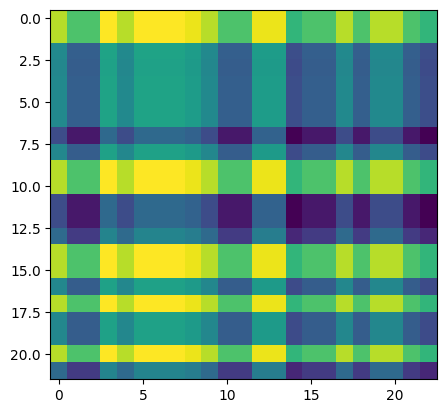

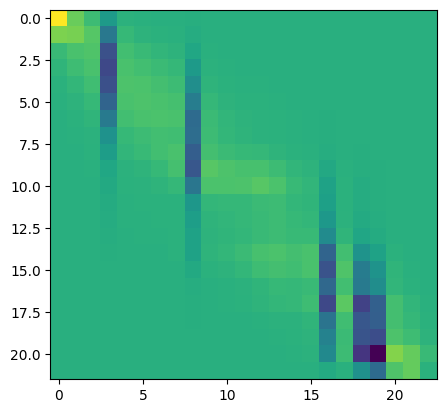

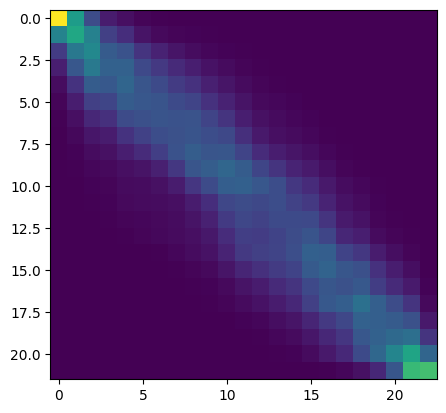

In [65]:
analyse()

## LSTM

In [4]:
from extra.models.rnnt import RNNT, LSTM
from tinygrad.nn import Linear, Embedding
from temp.lstm import LSTM
from tinygrad.helpers import Timing

In [5]:
emb = Embedding(C,10)
H = 100

class RNN:
    def __init__(self,dim:int):
        self.dim = dim
        self.layers = [
            LSTM(dim,H,1,0),
            LSTM(H,H,10,0),
            LSTM(H,dim,1,0)]

    def __call__(self,x:Tensor):
        for l in self.layers:
            x,_ = l(x,None)
        return x

rnn = RNN(10)
opt = Adam(get_parameters(rnn))

In [68]:
x = emb(labels)
# x = Tensor.uniform(20,4,10)
y = x[:,  1:].contiguous().realize()
x = x[:, :-1].contiguous().realize()

In [69]:
@TinyJit
def rnn_step(rnn,x,y):
    p = rnn(x.T)
    # loss = Tensor.sparse_categorical_crossentropy(p.T,y)
    loss = (p.T-y).square().mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss.realize(),p.realize()

In [70]:
# with Timing("all: "):
#     for i in range (500):
#         l,p = rnn_step(rnn,x,y)
#         if (i+1)%10==0:
#             print(f"\r {i}",l.numpy(),end="")
#     print()

## RNNT

In [71]:
from examples.mlperf.rnnt.model import RNNT
from tinygrad import Tensor

In [72]:
rnnt = RNNT()

In [73]:
Tensor.randint(5,15,low=0,high=29).max().numpy()

array(27, dtype=int32)

In [74]:
X = Tensor.uniform(20,5,240)
X_lens = Tensor.ones(5)*20
Y = Tensor.randint(5,15,high=29)

In [75]:

def dis(data_item):
    enc, xlens = rnnt.encoder(X,X_lens)
    preds,ylens = rnnt.prediction.__call__(Y,None,1)
    d = rnnt.joint(enc,preds).softmax(-1)
    return d, xlens,ylens,labels

## real data

In [9]:
from data import iterate
import numpy as np
from model import RNNT, LSTM
from tinygrad.nn.state import get_parameters
from tinygrad import Tensor

In [10]:
i2c = list("abcdefghijklmnopqrstuvwxyz' ")+["<pad>"]
c2i = dict(map(reversed,enumerate(i2c)))
C = len(i2c) # the last index stands for either the skip or pad. thesee are different.
def text_encode(s):
    if type(s[0]) == str: s = [s]
    lens = list(map(len,s))
    maxlen = max(lens)
    encs = [list(map(c2i.__getitem__,e)) + (maxlen-l) * [c2i['<pad>']] for e,l in zip(s,lens)]
    encs = np.array(encs)
    return encs,lens

In [3]:
X,labels = next(iterate(4))
X,X_lens = X
labels,Y_lens = text_encode(labels)

there are 2703 samples in the dataset


In [4]:
lstm = LSTM(240,5000,1,0)
for p in get_parameters(lstm):
    p.requires_grad = True

In [8]:
p, _ = lstm(Tensor(X),None)
p.realize()

AssertionError: out of memory - requested:  0.40 GB, available:  0.06 GB

In [40]:
for p in get_parameters(rnnt):
    p.requires_grad = True

In [47]:
rnnt.encoder.pre_rnn.cells[0].bias_hh

<Tensor <LB (4096,) dtypes.float op=buffer<4096, dtypes.float, 11289742672> st=ShapeTracker(views=(View(shape=(4096,), strides=(1,), offset=0, mask=None, contiguous=True),))> on GPU with grad None>

In [41]:
X,X_lens = rnnt.encoder.pre_rnn(Tensor(X),None)

AssertionError: out of memory - requested:  0.00 GB, available:  0.00 GB

In [27]:
X,labels = next(iterate(4))
X,X_lens = X
labels,Y_lens = text_encode(labels)
X,X_lens = rnnt.encoder.__call__(Tensor(X),X_lens) # LSTM expects (N,B,D)
Y,_ = rnnt.prediction(Tensor(labels),None,1)
Y = Y.pad(((0,0),(1,0),(0,0)))
d = rnnt.joint(X,Y).softmax(-1)

d = d.pad(((0,0),(0,1),(0,0),(0,0)))

maxx = max(X_lens) + 1
ar = Tensor.arange(maxx)
mask = (ar.unsqueeze(1) < Tensor(X_lens)).T
d = d * mask.unsqueeze(-1).unsqueeze(-1)
skip_mask = Tensor.eye(128)[Tensor(Y_lens)].unsqueeze(1).mul(1-mask.unsqueeze(-1))
skip_mask = skip_mask.unsqueeze(-1).mul(Tensor([0]*(C-1)+[1]).reshape((1,1,1,C)))
d = d + skip_mask
X,Y,d

there are 2703 samples in the dataset


AssertionError: out of memory - requested:  0.02 GB, available:  0.01 GB

In [75]:
loss = TransducerLoss.apply(d,
                     Tensor(labels),
                     )

AssertionError: out of memory - requested:  0.01 GB, available:  0.01 GB

In [70]:
ctx = loss._ctx

In [54]:
TransducerLoss.forward??

Signature:
TransducerLoss.forward(
    self,
    d: tinygrad.tensor.Tensor,
    labels: tinygrad.tensor.Tensor,
)
Docstring: <no docstring>
Source:   
    def forward(self, d:Tensor, labels:Tensor):
        self.B,self.X,self.Y,self.C = d.shape

        self.labels = Tensor(labels).pad(((0,0),(0,1)))
        self.lattice = shear(Tensor(d))
        self.X = self.X+self.Y-1
        assert self.lattice.shape == (self.B,self.X,self.Y,self.C), f"{self.lattice.shape}"

        self.skip = self.lattice[:,:,:,-1].log()
        self.p = self.lattice[
            Tensor(np.arange(self.B).reshape((-1,1,1))),
            Tensor(np.arange(self.X).reshape((1,-1,1))),
            Tensor(np.arange(self.Y).reshape((1,1,-1))),
            self.labels.reshape((self.B,1,-1))].log()

        assert self.p.shape == (self.B, self.X, self.Y)
        self.a = [Tensor([0]*self.B).reshape(-1,1).pad(((0,0),(0,self.Y-1),),-inf).realize()]

        for x in range(0,self.X-1):
            self.a.append(logsumexp((se

In [35]:
d = Tensor.ones(2,2, requires_grad = True)
y = d.pad(((0,1),(0,1)))
l = y.sum()
l.backward()
d.grad.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)